In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error,\
    mean_squared_error, mean_absolute_percentage_error

from catboost import CatBoostRegressor, Pool

d:\Repositories\mlops-russian-housing\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Чтение данных

In [35]:
df_org = pd.read_csv('../data/raw/houses_dataset.csv')
df_org.head(5)

,id,create_date,city_name,room_count,total_square,square_coock,square_rooms,floor,loggia,room_type,repair_type,home_type,year_build,max_floors,passanger_elevator,cargo_elevator,price
0,3979989757,2024-03-12 16:16:00,moskva,3.0,63.0,8.2,NaN,2,NaN,изолированные,евро,панельный,1972.0,9,NaN,NaN,13790000
1,3947772733,2024-03-12 16:14:00,moskva,2.0,72.0,20.0,40.0,30,NaN,изолированные,дизайнерский,монолитный,2023.0,41,NaN,NaN,34699000
2,3316902374,2024-03-12 16:08:00,moskva,1.0,16.3,5.0,NaN,1,NaN,NaN,евро,панельный,1968.0,9,NaN,NaN,4850000
3,3700140158,2024-02-19 13:19:00,moskva,3.0,75.0,10.2,44.0,4,лоджия,изолированные,косметический,панельный,1976.0,16,1.0,1.0,20300000
4,3423279221,2024-03-06 16:04:00,moskva,4.0,151.1,14.5,74.5,5,балкон,изолированные,дизайнерский,монолитный,1999.0,12,1.0,1.0,95000000


In [7]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  155 non-null    int64  
 1   create_date         155 non-null    object 
 2   city_name           155 non-null    object 
 3   room_count          138 non-null    float64
 4   total_square        155 non-null    float64
 5   square_coock        138 non-null    float64
 6   square_rooms        105 non-null    float64
 7   floor               155 non-null    int64  
 8   loggia              87 non-null     object 
 9   room_type           105 non-null    object 
 10  repair_type         146 non-null    object 
 11  home_type           155 non-null    object 
 12  year_build          100 non-null    float64
 13  max_floors          155 non-null    int64  
 14  passanger_elevator  78 non-null     float64
 15  cargo_elevator      48 non-null     float64
 16  price   

In [66]:
cat_features = ['city_name', 'room_count', 'loggia', 'room_type',
                'repair_type', 'home_type', 'passanger_elevator',
                'cargo_elevator']
continuous_features = ['total_square', 'square_coock',
                       'square_rooms', 'year_build',
                       'floor', 'max_floors']

In [133]:
# Сплит на train и test по времени
sample_size = len(df_org)
df_org.sort_values(by='create_date', inplace=True)

train_features = df_org.iloc[:int(0.85 * sample_size)]
test_features = df_org.iloc[int(0.85 * sample_size):]

In [134]:
train_features.head()

,id,create_date,city_name,room_count,total_square,square_coock,square_rooms,floor,loggia,room_type,repair_type,home_type,year_build,max_floors,passanger_elevator,cargo_elevator,price
104,3663495807,2024-02-18 20:11:00,kazan,3.0,89.0,11.3,60.0,7,лоджия,изолированные,косметический,кирпичный,2017.0,9,NaN,1.0,13900000
3,3700140158,2024-02-19 13:19:00,moskva,3.0,75.0,10.2,44.0,4,лоджия,изолированные,косметический,панельный,1976.0,16,1.0,1.0,20300000
107,3597982803,2024-02-20 23:10:00,kazan,NaN,17.0,NaN,NaN,3,NaN,NaN,евро,кирпичный,NaN,5,NaN,NaN,3450000
92,3540865211,2024-02-23 15:00:00,sankt-peterburg,3.0,55.5,5.5,40.3,2,балкон,изолированные,требует,кирпичный,1960.0,3,NaN,NaN,7050000
134,3537119358,2024-02-26 15:39:00,kazan,3.0,60.0,12.0,33.6,14,NaN,изолированные,дизайнерский,монолитно,2022.0,25,1.0,1.0,9900000


In [12]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 104 to 26
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  124 non-null    int64  
 1   create_date         124 non-null    object 
 2   city_name           124 non-null    object 
 3   room_count          108 non-null    float64
 4   total_square        124 non-null    float64
 5   square_coock        108 non-null    float64
 6   square_rooms        89 non-null     float64
 7   floor               124 non-null    int64  
 8   loggia              71 non-null     object 
 9   room_type           81 non-null     object 
 10  repair_type         119 non-null    object 
 11  home_type           124 non-null    object 
 12  year_build          85 non-null     float64
 13  max_floors          124 non-null    int64  
 14  passanger_elevator  61 non-null     float64
 15  cargo_elevator      36 non-null     float64
 16  price       

## EDA

Оцениваем количество значений и пропусков у категориальных фичей

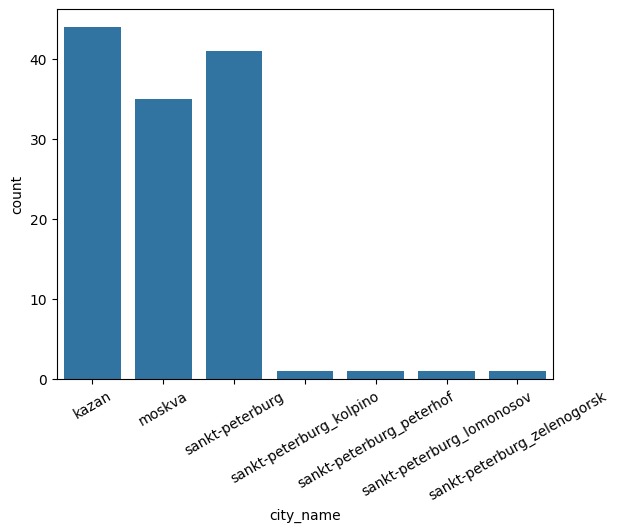

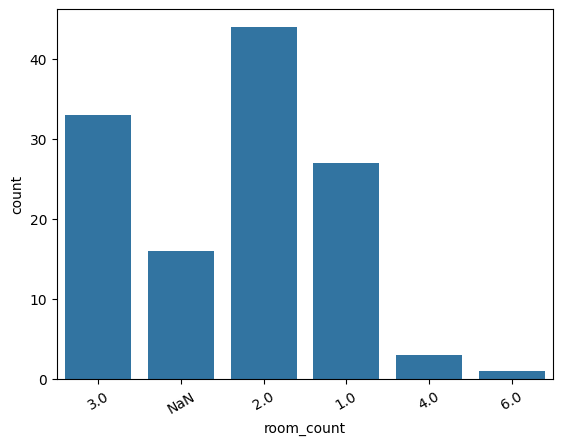

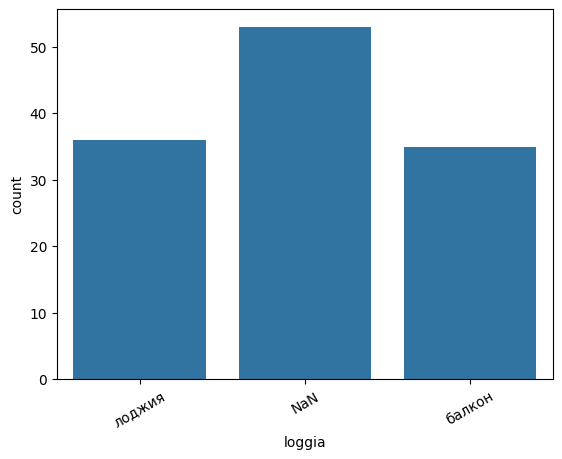

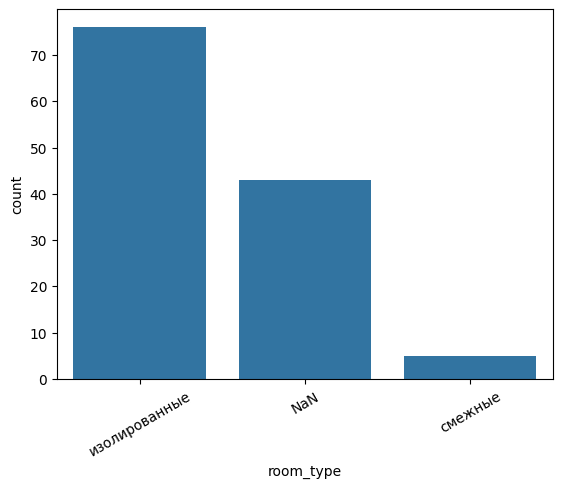

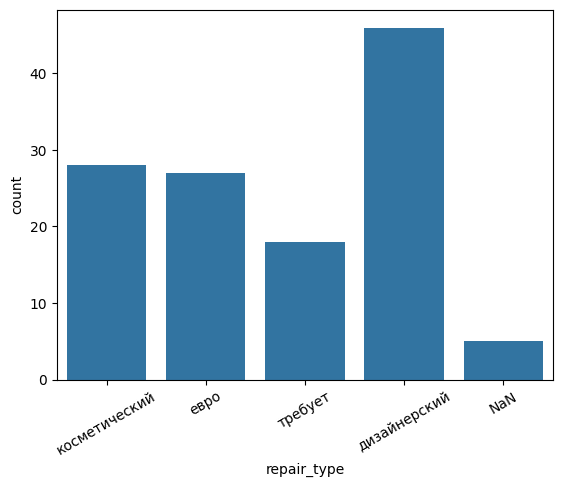

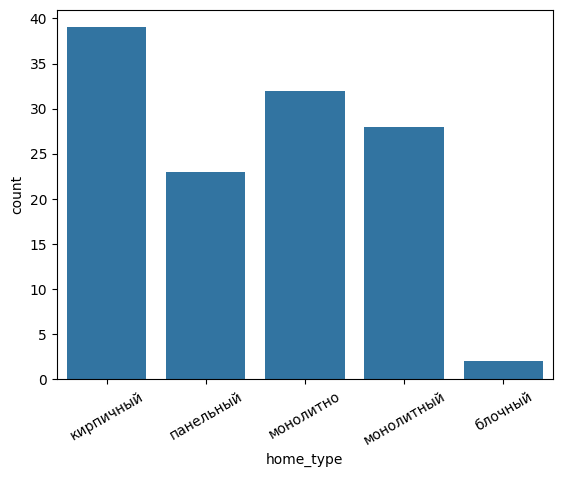

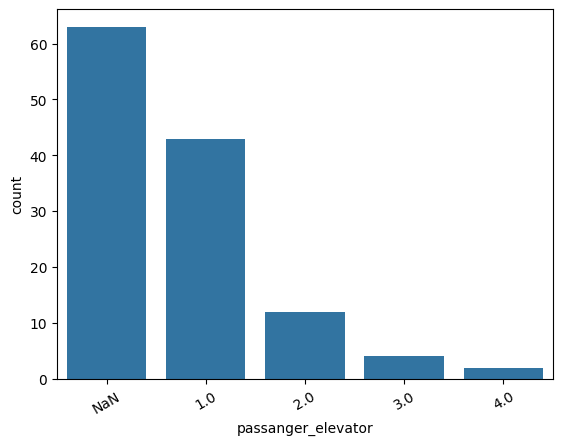

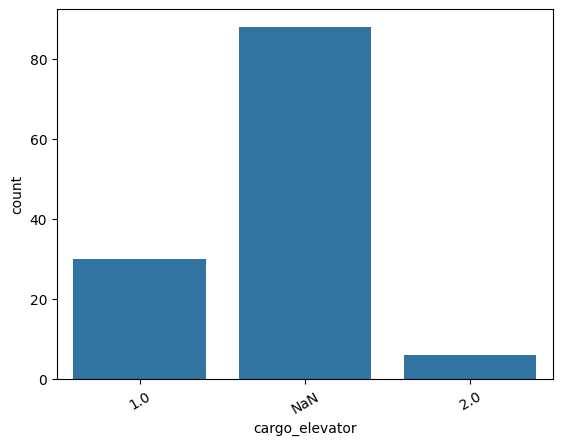

In [67]:
# Распределение категориальных фичей
for col in cat_features:
    sns.countplot(train_features.fillna('NaN'), x=col)
    plt.xticks(rotation=30);
    plt.show()

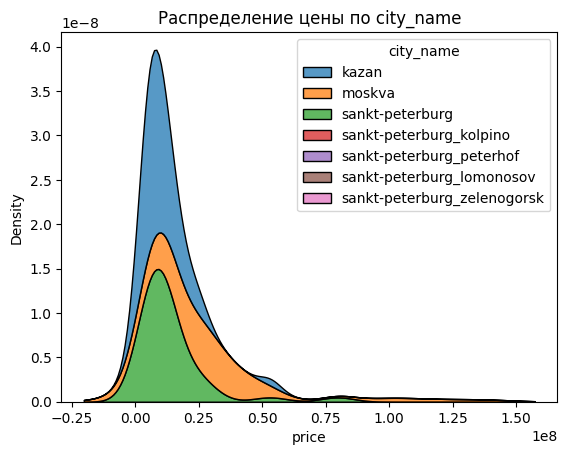

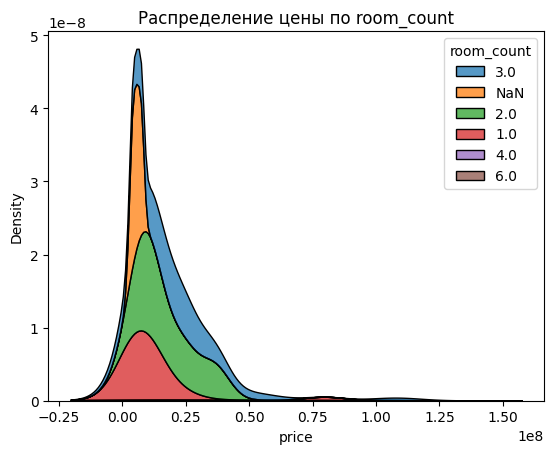

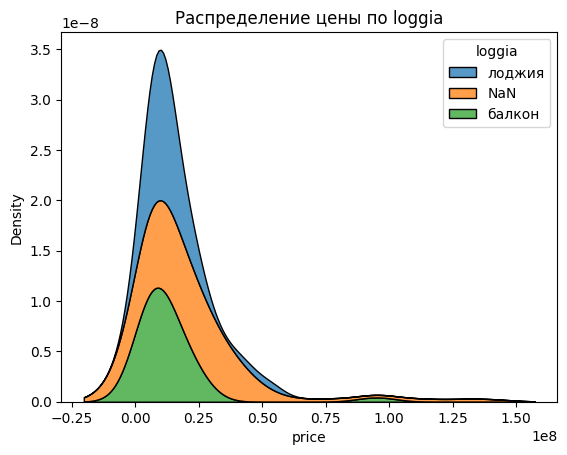

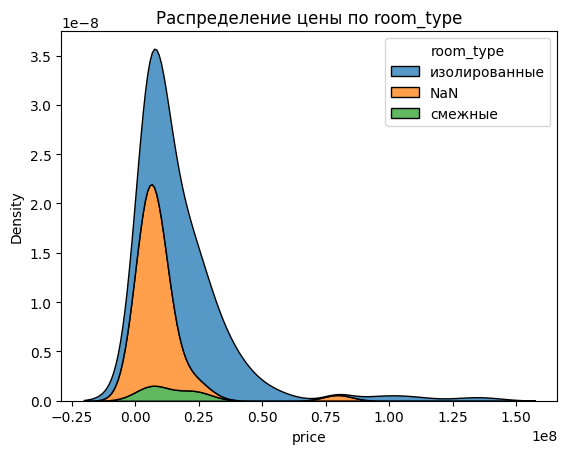

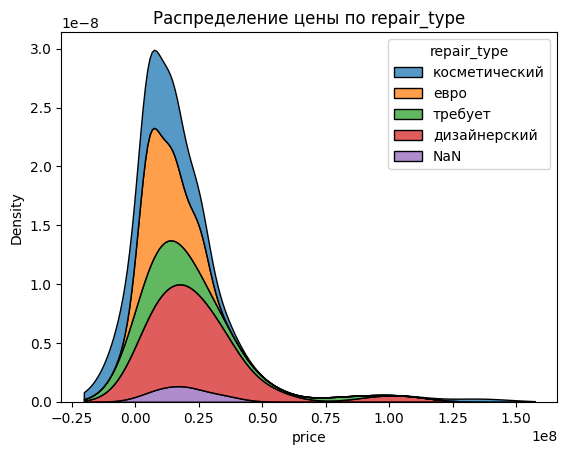

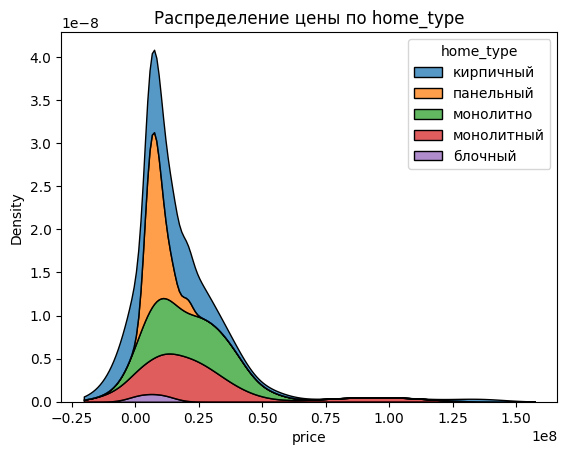

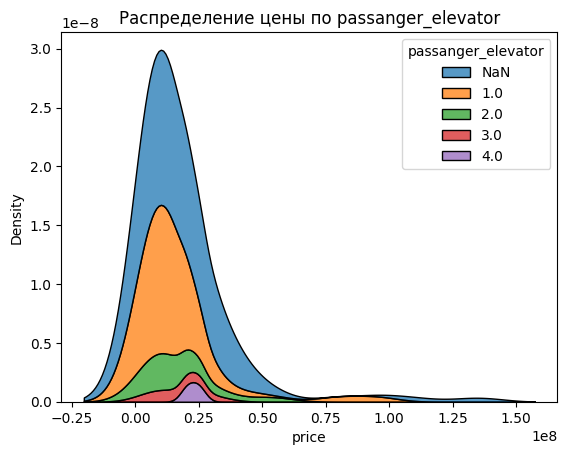

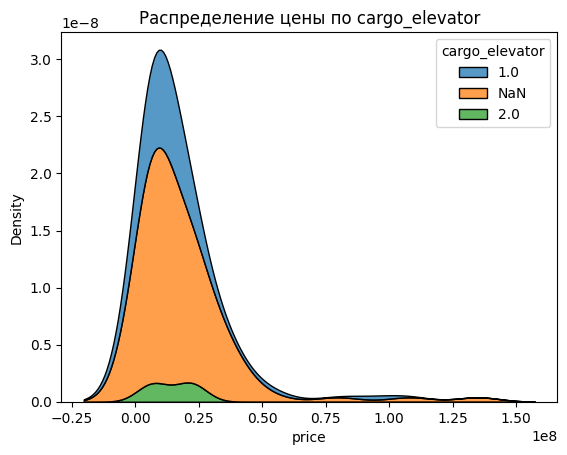

In [68]:
# Распределение фичей по таргету
for col in cat_features:
    sns.kdeplot(
        data=train_features.fillna('NaN'),
        x='price',
        hue=col,
        warn_singular=False,
        multiple="stack");
    plt.title(f"Распределение цены по {col}")
    plt.show();

Корреляция между признаками

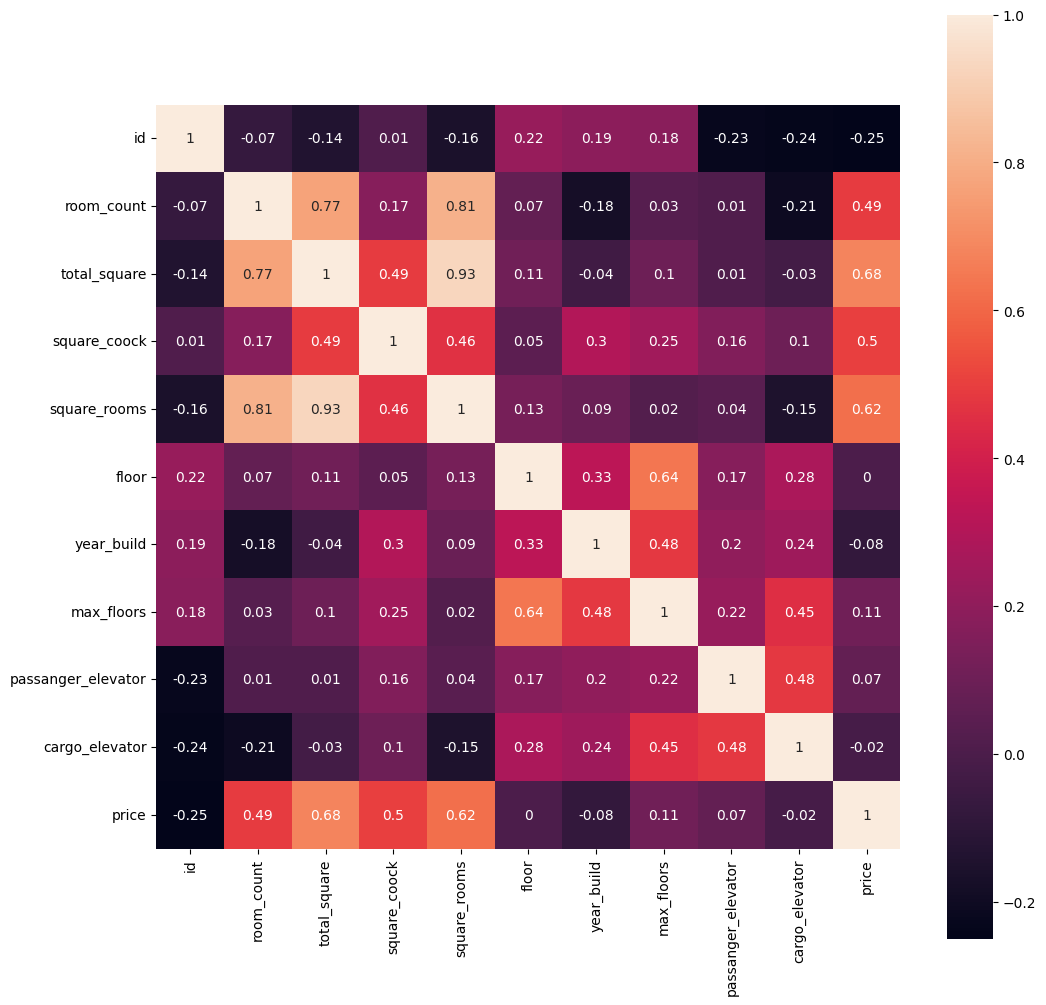

In [69]:
plt.figure(figsize=(12,12))
sns.heatmap(
    data=train_features.corr(numeric_only=True).round(2),
    square=True,
    annot=True,
);

<Figure size 1200x1200 with 0 Axes>

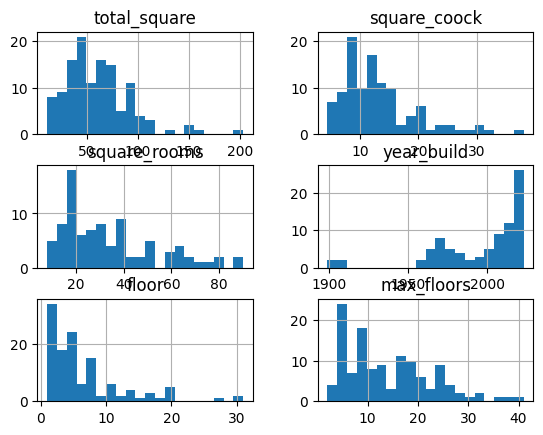

In [71]:
plt.figure(figsize=(12, 12))
train_features[continuous_features].hist(bins=20);

## Feature Engineering

In [57]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 104 to 26
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  124 non-null    int64  
 1   create_date         124 non-null    object 
 2   city_name           124 non-null    object 
 3   room_count          108 non-null    float64
 4   total_square        124 non-null    float64
 5   square_coock        108 non-null    float64
 6   square_rooms        89 non-null     float64
 7   floor               124 non-null    int64  
 8   loggia              71 non-null     object 
 9   room_type           81 non-null     object 
 10  repair_type         119 non-null    object 
 11  home_type           124 non-null    object 
 12  year_build          85 non-null     float64
 13  max_floors          124 non-null    int64  
 14  passanger_elevator  61 non-null     float64
 15  cargo_elevator      36 non-null     float64
 16  price       

In [101]:
def fill_nans(
        df_data: pd.DataFrame,
        median_fill_cols: list,
        mode_fill_cols: list
        ) -> pd.DataFrame:
    """Обработка пропусков в данных

    Args:
        df_data: Сырые данные в DataFrame
        median_fill_cols: столбцы, которые нужно заполнить медианой
        mode_fill_cols: столбцы, которые нужно заполнить модой
    Returns:
        df_proc: Данные без пропусков
    """
    df_proc = df_data.copy()

    for col in median_fill_cols:
        df_proc[col] = df_proc[col].fillna(df_proc[col].median())
    for col in mode_fill_cols:
        df_proc[col] = df_proc[col].fillna(df_proc[col].mode()[0])    

    return df_proc

In [125]:
median_fill_cols = [
    'square_coock',
    'square_rooms',
    'year_build'
    ]
mode_fill_cols = [
    'room_count',
    'loggia',
    'room_type',
    'repair_type',
    'passanger_elevator',
    'cargo_elevator'
    ]

train_data = fill_nans(train_features,
                       median_fill_cols,
                       mode_fill_cols)
test_data = fill_nans(test_features,
                      median_fill_cols,
                      mode_fill_cols)

In [126]:
def make_feature(
        df_data: pd.DataFrame,
        col_features: list,
        target_col: str=None
        ) -> pd.DataFrame:
    """Функция для генерация признаков

    Args:
        df_data: Сырые данные в DataFrame
        col_features: используемые столбцы для обучения
        target_col: название столбца таргета
    Returns:
        df_features: Итоговый данные для обучения   
    """
    use_cols = col_features.copy()
    if target_col:
        use_cols.append(target_col)
    df_features = df_data[use_cols].copy()

    if 'city_name' in use_cols:
        df_features['city_name'] = df_features['city_name'].apply(
            lambda x: 'sankt-peterburg' if 'sankt' in x else x
            )
    
    if target_col:
        df_features[target_col] = df_features[target_col].astype(float)

    return df_features

In [127]:
select_features = [
    'city_name',
    'room_count',
    'total_square',
    'square_coock',
    'square_rooms',
    'repair_type',
    'home_type',
    'year_build',
    'max_floors',
    'passanger_elevator'
]

train_data = make_feature(train_data,
                          col_features=select_features,
                          target_col='price')
test_data = make_feature(test_data,
                         col_features=select_features,
                         target_col='price')

In [131]:
train_data.head()

,city_name,room_count,total_square,square_coock,square_rooms,repair_type,home_type,year_build,max_floors,passanger_elevator,price
104,kazan,3.0,89.0,11.3,60.0,косметический,кирпичный,2017.0,9,1.0,13900000
3,moskva,3.0,75.0,10.2,44.0,косметический,панельный,1976.0,16,1.0,20300000
107,kazan,2.0,17.0,12.0,28.8,евро,кирпичный,2009.0,5,1.0,3450000
92,sankt-peterburg,3.0,55.5,5.5,40.3,требует,кирпичный,1960.0,3,1.0,7050000
134,kazan,3.0,60.0,12.0,33.6,дизайнерский,монолитно,2022.0,25,1.0,9900000


## Обучение модели CatBoost

In [3]:
train_data = pd.read_csv('../data/processed/train_houses.csv')
test_data = pd.read_csv('../data/processed/test_houses.csv')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   create_date         131 non-null    object 
 1   city_name           131 non-null    object 
 2   room_count          131 non-null    float64
 3   total_square        131 non-null    float64
 4   square_coock        131 non-null    float64
 5   square_rooms        131 non-null    float64
 6   repair_type         131 non-null    object 
 7   home_type           131 non-null    object 
 8   year_build          131 non-null    float64
 9   max_floors          131 non-null    int64  
 10  passanger_elevator  131 non-null    float64
 11  price               131 non-null    float64
dtypes: float64(7), int64(1), object(4)
memory usage: 12.4+ KB


In [5]:
train_data.sort_values(by='create_date', inplace=True)
train_data.drop(columns='create_date', inplace=True)

train_size = 0.85
data_size = len(train_data)
X_train = train_data.iloc[:int(train_size * data_size)]
X_valid = train_data.iloc[int(train_size * data_size):]

X_train, y_train = X_train.drop(columns='price'), X_train['price']
X_valid, y_valid = X_valid.drop(columns='price'), X_valid['price']

In [6]:
cat_features = ['city_name', 'repair_type', 'home_type']

train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

### Baseline

In [140]:
model = CatBoostRegressor(
    random_seed=42,
    thread_count=-1,
    cat_features=cat_features,
    eval_metric="MAE"
)

model.fit(
    train_pool,
    eval_set=valid_pool,
    verbose=5,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.036691
0:	learn: 10719210.9666439	test: 23924073.1190526	best: 23924073.1190526 (0)	total: 23.6ms	remaining: 23.6s
5:	learn: 9800803.0186698	test: 22890400.9148202	best: 22890400.9148202 (5)	total: 167ms	remaining: 27.7s
10:	learn: 8979403.1564993	test: 22228266.1431269	best: 22228266.1431269 (10)	total: 383ms	remaining: 34.4s
15:	learn: 8278674.4987061	test: 21737355.2468506	best: 21737355.2468506 (15)	total: 560ms	remaining: 34.4s
20:	learn: 7649228.8429466	test: 21087405.6827265	best: 21087405.6827265 (20)	total: 700ms	remaining: 32.6s
25:	learn: 7171531.6930232	test: 20607544.7630386	best: 20607544.7630386 (25)	total: 887ms	remaining: 33.2s
30:	learn: 6854383.6367824	test: 20226554.6394239	best: 20226554.6394239 (30)	total: 1.11s	remaining: 34.8s
35:	learn: 6445851.2228245	test: 19742722.3761370	best: 19742722.3761370 (35)	total: 1.28s	remaining: 34.2s
40:	learn: 6132636.2965823	test: 19531682.6445052	best: 19531682.6445052 (40)	total: 1.46s	remaining: 34.2s


### CatBoost Optuna

In [15]:
cb_init_params = {
    'eval_metric': 'MAE',
    'task_type': 'CPU',
    'random_seed': 42,
}

X_data, y_data = train_data.drop(columns='price'), train_data['price']

In [16]:
def objective_catboost(trial, return_models=False):
    kf = TimeSeriesSplit(n_splits=5)

    boosting_type = trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])

    if boosting_type == 'Ordered':
        bootstrap_type = 'No'
        grow_policy = 'SymmetricTree'
    else:
        bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
        grow_policy = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])

    if bootstrap_type == 'Bernoulli':
        subsample = trial.suggest_uniform('subsample', 0.4, 1)
    else:
        subsample = None

    trial_params = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10, log=True),
        'rsm': trial.suggest_float('rsm', 0.1, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
        'boosting_type': boosting_type,
        'bootstrap_type': bootstrap_type,
        'grow_policy': grow_policy,
        'use_best_model': True,
        'random_state': 42
    }

    if bootstrap_type == 'Bayesian':
        trial_params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 1e-2, 100, log=True)

    if bootstrap_type == 'Bernoulli':
        trial_params['subsample'] = subsample

    models = []
    mse_metrics, mae_metrics, mape_metrics, r2_metrics  = [], [], [], []
    for train_idx, valid_idx in kf.split(train_data):
        X_train, y_train = X_data.iloc[train_idx, :], y_data.iloc[train_idx]
        X_val, y_val = X_data.iloc[valid_idx, :], y_data.iloc[valid_idx]

        train_dataset = Pool(X_train, y_train, cat_features=cat_features)
        val_dataset = Pool(X_val, y_val, cat_features=cat_features)

        model = CatBoostRegressor(**trial_params)
        model.fit(train_dataset,
                  eval_set=val_dataset,
                  verbose=0,
                  early_stopping_rounds=30)

        y_pred = model.predict(val_dataset).reshape(-1)

        mse_metrics.append(mean_squared_error(y_val, y_pred))
        mae_metrics.append(mean_absolute_error(y_val, y_pred))
        mape_metrics.append(mean_absolute_percentage_error(y_val, y_pred))
        r2_metrics.append(r2_score(y_val, y_pred))

        models.append(model)

    result = np.mean(mae_metrics) + np.std(mae_metrics)

    if return_models:
        return result, models
    else:
        return result

In [17]:
study = optuna.create_study(direction='minimize',
                            sampler=TPESampler(seed=42),
                            pruner=MedianPruner())
study.optimize(objective_catboost,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True)

[I 2024-03-24 18:11:08,725] A new study created in memory with name: no-name-7b283616-173a-4917-85fe-e4f298df71d4
  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Vladislav\AppData\Local\Temp\ipykernel_7716\1306023376.py:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.4, 1)
Best trial: 1. Best value: 9.13451e+06:  10%|█         | 1/10 [00:23<03:34, 23.86s/it]

[I 2024-03-24 18:11:32,554] Trial 1 finished with value: 9134508.657829728 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'learning_rate': 0.07710705705445939, 'depth': 5, 'l2_leaf_reg': 0.08172977542253883, 'random_strength': 9.304336607377298, 'rsm': 0.1778260236950455, 'border_count': 22, 'leaf_estimation_method': 'Newton', 'min_data_in_leaf': 1}. Best is trial 1 with value: 9134508.657829728.


Best trial: 1. Best value: 9.13451e+06:  20%|██        | 2/10 [01:10<04:58, 37.26s/it]

[I 2024-03-24 18:12:19,219] Trial 7 finished with value: 10570457.966315016 and parameters: {'boosting_type': 'Ordered', 'learning_rate': 0.12301615110959697, 'depth': 9, 'l2_leaf_reg': 2.439486816347954, 'random_strength': 0.049594457821404536, 'rsm': 0.7989316281013393, 'border_count': 93, 'leaf_estimation_method': 'Newton', 'min_data_in_leaf': 1}. Best is trial 1 with value: 9134508.657829728.


Best trial: 1. Best value: 9.13451e+06:  30%|███       | 3/10 [01:32<03:32, 30.37s/it]

[I 2024-03-24 18:12:41,385] Trial 2 finished with value: 10805792.060831517 and parameters: {'boosting_type': 'Ordered', 'learning_rate': 0.026322061491633256, 'depth': 7, 'l2_leaf_reg': 0.003701378382586099, 'random_strength': 0.0033846843337311137, 'rsm': 0.6327490168596787, 'border_count': 216, 'leaf_estimation_method': 'Gradient', 'min_data_in_leaf': 7}. Best is trial 1 with value: 9134508.657829728.


Best trial: 1. Best value: 9.13451e+06:  40%|████      | 4/10 [01:35<01:57, 19.62s/it]

[I 2024-03-24 18:12:44,521] Trial 4 finished with value: 9718014.078902613 and parameters: {'boosting_type': 'Ordered', 'learning_rate': 0.014814245319559702, 'depth': 4, 'l2_leaf_reg': 0.07132138924461028, 'random_strength': 1.1693332753264194, 'rsm': 0.45610226668374076, 'border_count': 222, 'leaf_estimation_method': 'Newton', 'min_data_in_leaf': 9}. Best is trial 1 with value: 9134508.657829728.


Best trial: 1. Best value: 9.13451e+06:  50%|█████     | 5/10 [01:40<01:10, 14.13s/it]

[I 2024-03-24 18:12:48,905] Trial 5 finished with value: 10543214.600640517 and parameters: {'boosting_type': 'Ordered', 'learning_rate': 0.017054825834783155, 'depth': 5, 'l2_leaf_reg': 0.08031275726575629, 'random_strength': 0.006519042741981188, 'rsm': 0.8090564688762214, 'border_count': 194, 'leaf_estimation_method': 'Gradient', 'min_data_in_leaf': 10}. Best is trial 1 with value: 9134508.657829728.


Best trial: 1. Best value: 9.13451e+06:  60%|██████    | 6/10 [01:58<01:02, 15.67s/it]

[I 2024-03-24 18:13:07,564] Trial 8 finished with value: 10015696.985823832 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'learning_rate': 0.16111547894232675, 'depth': 6, 'l2_leaf_reg': 0.45932619870882824, 'random_strength': 0.01077123010407038, 'rsm': 0.3165506493007644, 'border_count': 112, 'leaf_estimation_method': 'Newton', 'min_data_in_leaf': 5, 'bagging_temperature': 28.475376110310556}. Best is trial 1 with value: 9134508.657829728.


Best trial: 1. Best value: 9.13451e+06:  70%|███████   | 7/10 [03:36<02:07, 42.58s/it]

[I 2024-03-24 18:14:45,560] Trial 9 finished with value: 9784019.912432369 and parameters: {'boosting_type': 'Ordered', 'learning_rate': 0.04163815290015743, 'depth': 9, 'l2_leaf_reg': 0.9782267700960317, 'random_strength': 1.3161525782464414, 'rsm': 0.3717202761363593, 'border_count': 105, 'leaf_estimation_method': 'Gradient', 'min_data_in_leaf': 3}. Best is trial 1 with value: 9134508.657829728.


Best trial: 3. Best value: 8.9039e+06:  80%|████████  | 8/10 [03:43<01:02, 31.02s/it] 

[I 2024-03-24 18:14:51,818] Trial 3 finished with value: 8903900.894779969 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'subsample': 0.6115098715094445, 'learning_rate': 0.08961672114015133, 'depth': 8, 'l2_leaf_reg': 0.060624474569875755, 'random_strength': 0.0038847782978532713, 'rsm': 0.771489029396944, 'border_count': 45, 'leaf_estimation_method': 'Gradient', 'min_data_in_leaf': 3}. Best is trial 3 with value: 8903900.894779969.


Best trial: 0. Best value: 8.54308e+06:  90%|█████████ | 9/10 [04:24<00:34, 34.40s/it]

[I 2024-03-24 18:15:33,644] Trial 0 finished with value: 8543081.48606019 and parameters: {'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'learning_rate': 0.037297597071406306, 'depth': 7, 'l2_leaf_reg': 0.12185690368805563, 'random_strength': 1.5112665096214164, 'rsm': 0.6975599491377841, 'border_count': 176, 'leaf_estimation_method': 'Newton', 'min_data_in_leaf': 1, 'bagging_temperature': 0.03690571959358184}. Best is trial 0 with value: 8543081.48606019.


Best trial: 0. Best value: 8.54308e+06:  90%|█████████ | 9/10 [04:30<00:30, 30.00s/it]

[W 2024-03-24 18:15:38,713] Trial 6 failed with parameters: {'boosting_type': 'Ordered', 'learning_rate': 0.011521077024736391, 'depth': 10, 'l2_leaf_reg': 2.3477110959374414, 'random_strength': 0.9924185293549015, 'rsm': 0.9227642649974226, 'border_count': 169, 'leaf_estimation_method': 'Gradient', 'min_data_in_leaf': 7} because of the following error: RuntimeError('Attempt to pop from an empty stack').
Traceback (most recent call last):
  File "d:\Repositories\mlops-russian-housing\env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Vladislav\AppData\Local\Temp\ipykernel_7716\1306023376.py", line 51, in objective_catboost
    model.fit(train_dataset,
  File "d:\Repositories\mlops-russian-housing\env\Lib\site-packages\catboost\core.py", line 5807, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseli

In [18]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 8543081.48606019, params {'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'grow_policy': 'Depthwise', 'learning_rate': 0.037297597071406306, 'depth': 7, 'l2_leaf_reg': 0.12185690368805563, 'random_strength': 1.5112665096214164, 'rsm': 0.6975599491377841, 'border_count': 176, 'leaf_estimation_method': 'Newton', 'min_data_in_leaf': 1, 'bagging_temperature': 0.03690571959358184}


In [19]:
valid_scores, models = objective_catboost(
    optuna.trial.FixedTrial(study.best_params),
    return_models=True
)